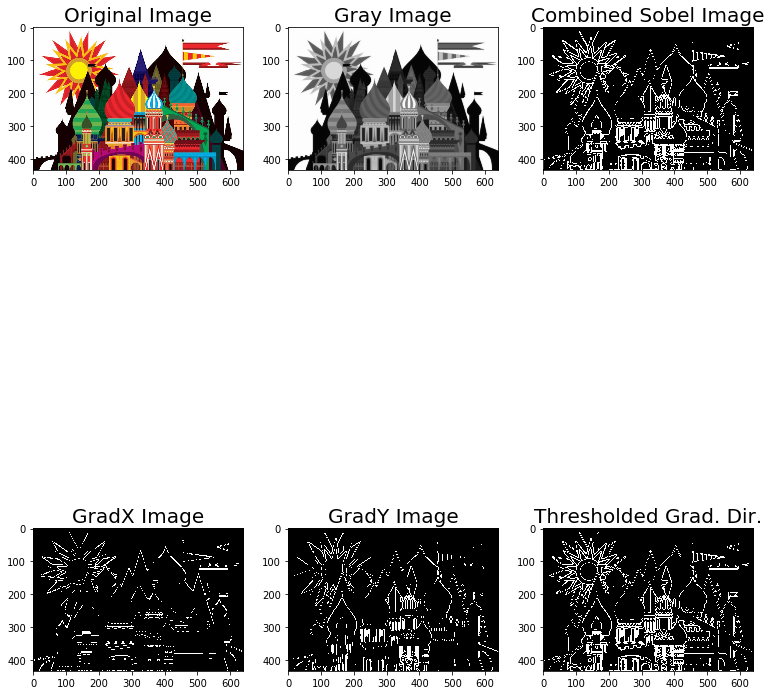

In [1]:
import numpy as np
import matplotlib.pylab as plt
import cv2
import math
import time

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


def gaussian_blur(A, kernel = 5): 
    width, height = A.shape
  #  Print 'tamaño', ancho, 'x', altura,
    A = A.astype(np.float)
    B = A
    for j in range(2,height-2): 
        for i in range(2,width-2):
            B[i,j] = math.floor((0.000252*(A[i-2,j-2]+A[i+2,j-2]+A[i-2,j+2]+A[i+2,j+2])) + (0.00352*(A[i-1,j-2]+A[i+1,j-2]+A[i-1,j+2]+A[i+1,j+2]+A[i-2,j-1]+A[i+2,j-1]+A[i+2,j+1]+A[i-2,j+1])) + (0.008344*(A[i,j-2]+A[i,j+2]+A[i-2,j]+A[i+2,j])) + (0.049081*(A[i-1,j-1]+A[i+1,j-1]+A[i-1,j+1]+A[i+1,j+1])) +(0.11634*(A[i,j-1]+A[i-1,j]+A[i+1,j]+A[i,j+1])) +(0.275768*A[i,j]))   
    return B


def sobel_filter(A, x, y, sobel_kernel=3):
    width, height = A.shape
    A = A.astype(np.float)
    B = np.zeros((width, height))
    if x == 1:
        for j in range(1, height-1): 
            for i in range(1, width-1):
                B[i,j] = (2*A[i+1,j] + A[i+1,j+1] + A[i+1,j-1] - (A[i-1,j-1] + A[i-1,j+1] + 2*A[i-1,j]))
    else:
        for j in range(1, height-1): 
            for i in range(1, width-1):
                B[i,j] = (A[i+1,j-1] + A[i-1,j-1] + 2*A[i,j-1] - (A[i-1,j+1] + A[i+1,j+1] + 2*A[i,j+1]))      
    return B


global glbsobelx, glbsobely

def C(image,sobel_kernel=3):
    global glbsobelx, glbsobely
    glbsobelx = sobel_filter(image, 1, 0, sobel_kernel)
    glbsobely = sobel_filter(image, 0, 1, sobel_kernel)
    

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calcular gradiente direccional
    if orient == 'x':
        x,y = 1,0
        sobel = glbsobelx
    elif orient == 'y':
        x,y = 0,1
        sobel = glbsobely

    # Tomar el valor absoluto de la derivada o gradiente
    abs_sobel = np.absolute(sobel)

    # Escala a 8 bits (0 - 255) y luego convertir a type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Crear una máscara de 1 donde la magnitud escalonada del gradiente
    # Es > thresh_min y < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
  # Print 'abs_sobel_thresh hecho'
    return sbinary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calcular la magnitud del gradiente
    # Tome el gradiente en x e y por separado
    sobelx = glbsobelx
    sobely = glbsobely
    
    # Calcular la magnitud 
    abs_sobel = np.sqrt(sobelx**2 +sobely**2)

    # Escala a 8 bits (0 - 255) y convierte a type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sbinary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calcular la dirección del gradiente
    # Tome el gradiente en x e y por separado
    sobelx = glbsobelx
    sobely = glbsobely
    
    # Tome el valor absoluto de los gradientes x e y
    abs_sobelx = np.absolute(sobelx)   
    abs_sobely = np.absolute(sobely)
    
    # Utilice np.arctan2 (abs_sobely, abs_sobelx) para calcular la dirección del gradiente
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # Cree una máscara binaria donde se cumplan los umbrales de dirección
    sbinary = np.zeros_like(grad_dir)
    sbinary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return sbinary

im = plt.imread("Imagen1.jpg")
gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

# Filtro de Desenfoque Gaussiano
gray = gaussian_blur(gray, kernel = 5)

# Elija un tamaño de kernel Sobel
ksize = 3 # Elija un número impar más grande para suavizar las mediciones de gradiente

# Aplicar cada una de las funciones de umbral
C(gray)
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(40, 110))
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(40, 110))
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(30, 90))
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0, np.pi/2))

# Crear imagen combinada con filtros sobel aplicados
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
rgb_combined = np.asarray(np.dstack((combined, combined, combined)), dtype=np.float64)

# Trazar el resultado
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 15))
f.tight_layout()
ax1.imshow(im)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(gray, cmap='gray')
ax2.set_title('Gray Image', fontsize=20)
ax3.imshow(rgb_combined, cmap='gray')
ax3.set_title('Combined Sobel Image', fontsize=20)
ax4.imshow(gradx, cmap='gray')
ax4.set_title('GradX Image', fontsize=20)
ax5.imshow(grady, cmap='gray')
ax5.set_title('GradY Image', fontsize=20)
ax6.imshow(((mag_binary == 1) & (dir_binary == 1)), cmap='gray')
ax6.set_title('Thresholded Grad. Dir.', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [ ]:
def process_image(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = gaussian_blur(gray, kernel = 5)
    # Elija un tamaño de kernel Sobel
    ksize = 3 # Elija un número impar más grande para suavizar las mediciones de gradiente

    # Aplicar cada una de las funciones de umbral
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(50, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0, np.pi/4))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    
    rgb_combined = np.asarray(np.dstack((combined, combined, combined)), dtype=np.uint8)
    
    retval, threshold = cv2.threshold(rgb_combined, 0, 255, cv2.THRESH_BINARY)
    
    return threshold

filter_output = 'Batman_Filter.mp4'
clip1 = VideoFileClip("Batman.mp4")
batman_clip = clip1.fl_image(process_image) #NOTA: ¡Ésta función espera imágenes en color!
%time batman_clip.write_videofile(filter_output, audio=False)

HTML("""
<video width="720" height="480" controls>
  <source src="{0}">
</video>
""".format(filter_output))


MoviePy: building video file Batman_Filter.mp4
----------------------------------------

Writing video into Batman_Filter.mp4
|#---------| 46/265  17% [elapsed: 25:29 left: 2:01:19,  0.03 iters/sec]

In [3]:
cap = cv2.VideoCapture(0)

out = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*"MJPG"), 20,(640,480))

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        frame = cv2.flip(frame,180)
        new_frame = process_image(frame)
        out.write(new_frame)

        cv2.imshow('frame',new_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Liberar todo si el trabajo ha terminado
cap.release()
out.release()
cv2.destroyAllWindows()